# Use Adobe fonts website to generate >10k different number images for later machine learning. Some image pre-processing is included.

### Note: some cell output displays are not included for the ease of visualization. Final images can be found in "Mined_Processed_Images" in this Github project folder.

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.touch_actions import TouchActions
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from PIL import Image, ImageGrab
import time
import numpy as np
import glob
from IPython.display import display
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import shutil
import re
import random
%matplotlib inline

In [ ]:
first_page_url = 'https://fonts.adobe.com/fonts?browse_mode=default&sort=alpha&page=1'
delay = 0.1 # General time waits between some operations.

ideal_font_size = 60 # Output text size will be adjusted as closely to this as possible. 60 seems like a good text size for image capture. Not too small to cause low final image signal quality, not too large for text to be outside the predefined coordinates of screenshot region.
initial_slide = 100 # initially change the font size by 100 pixels to see how actual letter/number size changes.

final_image_size = (28, 28) # Like MNIST dataset, final images will be 28 x 28 pixels 

# Parameters for screen capture rendered numbers. May differ depending on computer setup.
box_width = 112 # How large the screenshot area is to capture the taget numbers. Keep this just large enough to capture most numbers & digits displayed on the webpage, but not too large to overwhelm computer storage capacity.
box_left = 105 # Leftmost position of the screen capture region, in pixel.
box_up = 1240 # Topmost position of the screen capture region, in pixel.

english_letters = ['A', 'a', 'B', 'b', 'C', 'c', 'D', 'd', 'E', 'e', 'F', 'f', 'H', 'h', 'G', 'g', 'I', 'i', 'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n', 'O', 'o', 'P', 'p', 'Q', 'q', 'R', 'r', 'S', 's', 'T', 't', 'U', 'u', 'V', 'v', 'W', 'w', 'X', 'x', 'Y', 'y', 'Z', 'z'] # Can be used to harvest letters w/ slight code modifications.

chrome_options = Options()
driver = webdriver.Chrome("/Users/zhonggao/Documents/Jupyter/chromedriver", options=chrome_options)
driver.get(first_page_url)
wait = WebDriverWait(driver, delay)

# Wait until the next button is rendered
wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/main/div[2]/div/div[2]/div[2]/div[2]/div/div/tk-paginate/div/div/nav/a[9]')))
total_pages = int(driver.find_element_by_xpath('/html/body/main/div[2]/div/div[2]/div[2]/div[2]/div/div/tk-paginate/div/div/nav/a[8]').text)

# Visit each browsing page containing (usually 12) fonts.
for page in range(2, total_pages + 1): # update to total_pages. TODO: VERIFY total_pages 138
    # Wait until the fonts are rendered on page.
    wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/main/div[2]/div/div[2]/div[2]/div[2]/div/div/ul/li[1]/a/div[1]/div/div')))
    
    font_url_containers = driver.find_elements_by_class_name('adobe-fonts-family-card--grid-view')
    
    font_urls = [i.get_attribute('href') for i in font_url_containers]
    
    for font_url in font_urls:
        if 'arabic' in font_url.lower() or 'hebrew' in font_url.lower(): # Arabic & Hebrew text starts from right to left, ignore these outliders.
            break
        elif 'outline' in font_url.lower(): # Ignore outline fonts as they render horrow instead of solid numbers.
            break
        driver.get(font_url)
        # Wait until the texts are rendered
        wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="fonts-section"]/div/ul/li')))
        
        # Scroll down for visual inspection as well as allowing screen capture via ImageGrab later.
        driver.execute_script("window.scrollTo(0, 100)")
        
        text_input_box = driver.find_element_by_xpath("/html/body/main/div[2]/div[4]/div/div/div/div[2]/div/input")
        font = driver.find_element_by_xpath('//*[@id="fonts-section"]/div/ul/li/div/div[1]/div[1]/span').text
        print('Font: ', font)

        # Enter 0 as a test to adjust number size
        text_input_box.clear()
        text_input_box.send_keys('0')
        text = driver.find_element_by_xpath('//*[@id="fonts-section"]/div/ul/li[1]/div/div[2]/div/div/div')
        
        # Find font size slider
        font_size_slider = driver.find_element_by_xpath('/html/body/main/div[2]/div[4]/div/div/div/div[3]/div/div[2]/input')
        slide = ActionChains(driver)

        # Center font size slider position
        slide.click_and_hold(font_size_slider).move_by_offset(0, 0).release().perform()

        # Wait until the size updates
        time.sleep(delay)
        c_text_height = text.size['height']
        
        # Adjust the font size as close to ideal font size as possible.
        slide.click_and_hold(font_size_slider).move_by_offset(initial_slide, 0).release().perform()
        time.sleep(delay)
        n_text_height = text.size['height']

        # Set numbers to the best-fitted height for later screen capture.
        correct_slide_pos = (ideal_font_size - c_text_height) / (n_text_height - c_text_height) * initial_slide
        slide.click_and_hold(font_size_slider).move_by_offset(correct_slide_pos, 0).release().perform()

        time.sleep(0.2)
        print('final text height: ', text.size['height'])
        
        vertical_pixel_offset = 0
        # Some font webpages render a special acvertisement line item which bumps the target text lower in pixel.
        if driver.find_element_by_xpath('//*[@id="fonts-section"]/div/div/div[2]').text != '':
            vertical_pixel_offset += 80
        else:
            pass
        
        try:
            desc_box_height = driver.find_element_by_xpath('/html/body/main/div[2]/div[2]/div/div/div/div[1]/div[1]/h2').size['height']
        except:
            desc_box_height = 0
            
        if desc_box_height > 24:
            vertical_pixel_offset += 50 * (desc_box_height / 24 - 1)
        else:
            pass
        
        # Enter digits 0~9 consecutively for image capture
        for num in range(10):
            text_input_box.clear()
            text_input_box.send_keys(num)
            time.sleep(delay)
            while True:
                if driver.find_element_by_xpath('//*[@id="fonts-section"]/div/ul/li/div/div[2]/div/div/div').text == str(num):
                    coords = [box_left, box_up + vertical_pixel_offset, box_left + box_width, box_up + box_width + vertical_pixel_offset]
                    text_img = ImageGrab.grab(bbox=coords).convert('L')
                    
                    break
                else:
                    time.sleep(0.1)
            # Change the image size to 28 x 28 & save to respective folders for the ease of forming training, validation & test sets
            text_img_mini = text_img.thumbnail(final_image_size, Image.ANTIALIAS)
            text_img.save('/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/{num}/{font}_{num}.png'.format(font=font, num=num))

    
    # Go to next page of fonts.
    driver.get(re.search(r'.*page=', first_page_url).group() + str(page))
    print('----------- Current Page #: ', page)
    
    

### For illustation purposes, only ~70% of the fonts were mined. Let's get a tally of how many raw images were captured from operation above.

### This GIF illustrates the mining process: https://github.com/ZhongRabbit/hobby_project/blob/master/Mining%20MNIST%20Numbers/Animation%20(numbers%20mining).gif

### Let's see how many raw images were captured from data collection.

In [20]:
orig_file_count = 0

for num in range(10):
    orig_file_path = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/{num}/'.format(num=num)
    
    orig_num_files = len(glob.glob(orig_file_path + '*.png'))
    
    print('Number {num} has {orig_num_files} raw images'.format(num=num, orig_num_files=orig_num_files))
    
    orig_file_count += orig_num_files

print('\nTotal raw images: ', orig_file_count)


Number 0 has 1237 raw images
Number 1 has 1237 raw images
Number 2 has 1237 raw images
Number 3 has 1237 raw images
Number 4 has 1237 raw images
Number 5 has 1237 raw images
Number 6 has 1237 raw images
Number 7 has 1237 raw images
Number 8 has 1237 raw images
Number 9 has 1237 raw images

Total raw images:  12370


### Make a plot function to visualize these collected number images.

In [2]:
def plots(filepath,
          figsize=(20,6),
          columns = 10,
          random_state = False):
    f = plt.figure(figsize=figsize)
    cols = min(len(glob.glob(filepath + '*.png')), columns)
    if random_state:
        selected_files = random.sample(glob.glob(filepath + '*.png'), columns)
    else:
        selected_files = sorted(glob.glob(filepath + '*.png'))
    for index, file in enumerate(selected_files):
        if index >= columns:
            break
        else:
            font_abbr = re.search(r'/\d/.*', file).group()[3:7]
            num_plot = f.add_subplot(1, cols, index + 1)
            image = Image.open(file)
            plt.imshow(image, interpolation=None)
            plt.xticks([])
            plt.yticks([])
            num_plot.set_title(font_abbr)
        
    plt.show()

### Randomly display 10 images for each number. What kind of processing do we need to correct imperfections of these images?

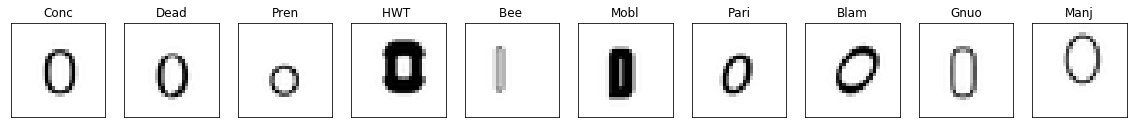

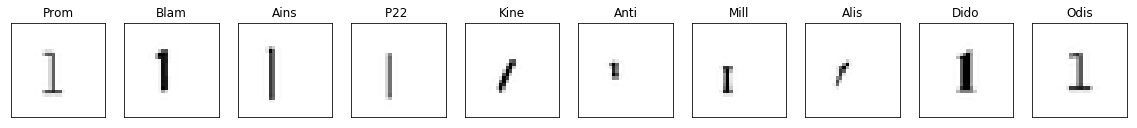

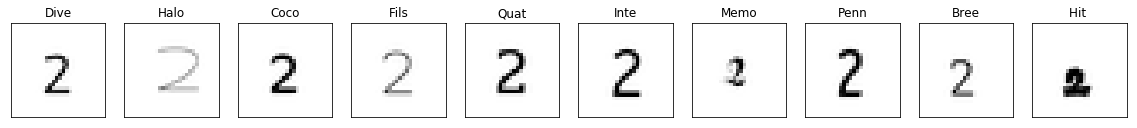

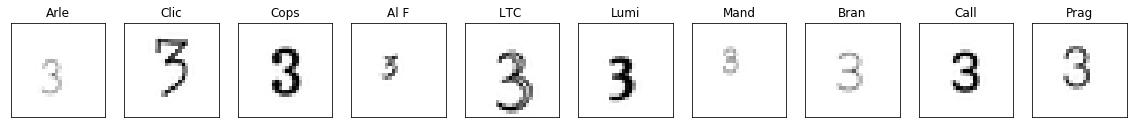

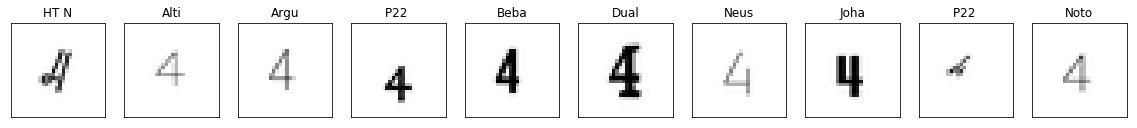

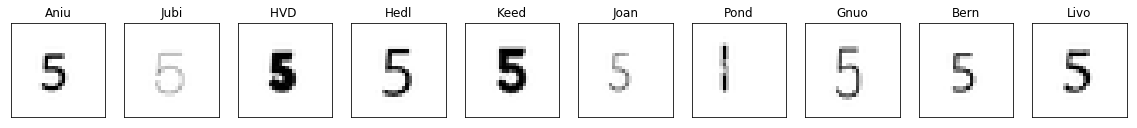

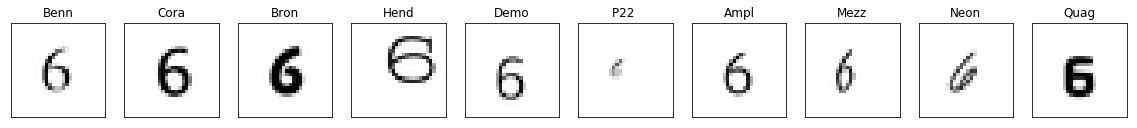

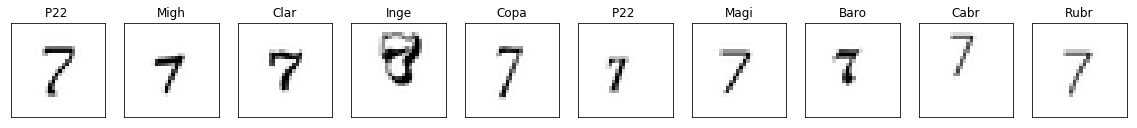

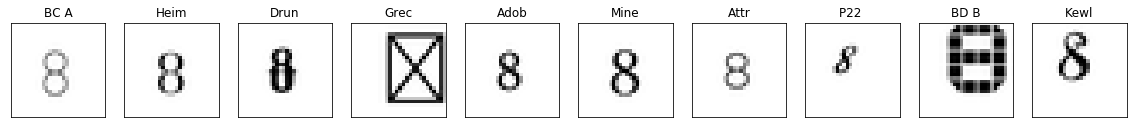

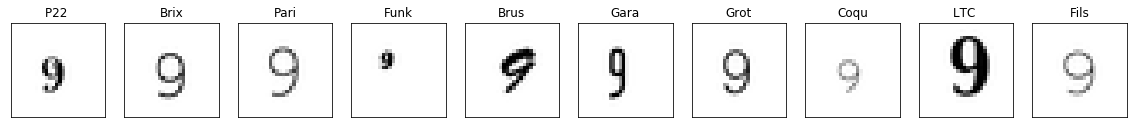

In [3]:
for num in range(10):
    file_path = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/{num}/'.format(num=num)
    plots(filepath=file_path, random_state=True)

### Looks like we have lots of processing to do to improve these images. 
### Let's pick a few problematic fonts to categorize some troubling aspects needing attention.

In [247]:
example_fonts = ['BadDog Regular', # std
                 'AWConqueror Std Sans Light', # std
                 'Goodlife Brush', # std
                 'BigCity Grotesque Pro Hairline', # light
                 'Brandon Grotesque Thin', # light
                 'Hummingbird Regular', # small
                 'Joschmi Regular', # top
                 'Madrone Std Regular', # right
                 'Ingeborg Block', # odd
                 'Fit Regular']
                 

for num in range(10):
    main_filepath = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/{num}/'.format(num=num)
    destination_filepath = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/example/{num}/'.format(num=num)
    os.mkdir(destination_filepath)
    for file in glob.glob(main_filepath + '*.png'):
        for example_font in example_fonts:
            if example_font in file:
                shutil.copy(file, destination_filepath)

            

## Some example images prior to pre-processing:

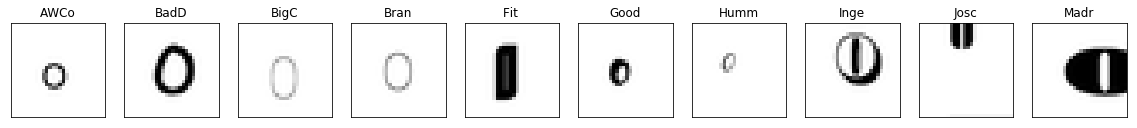

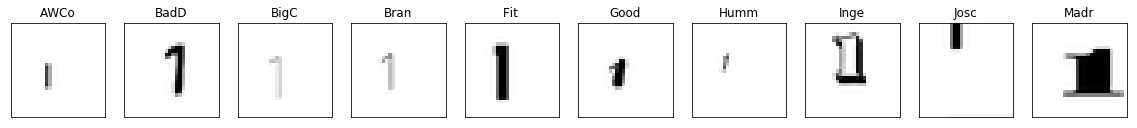

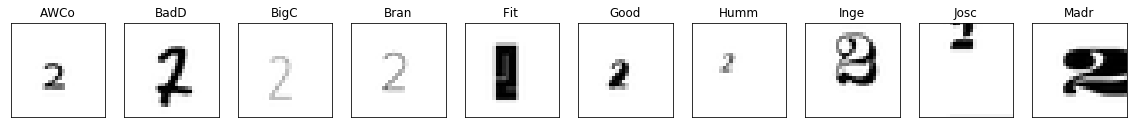

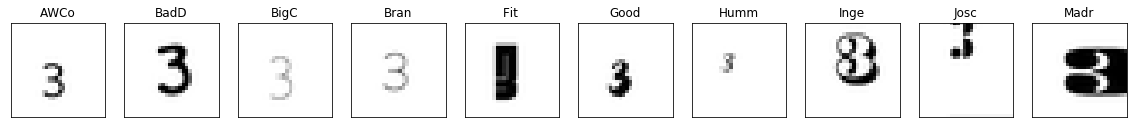

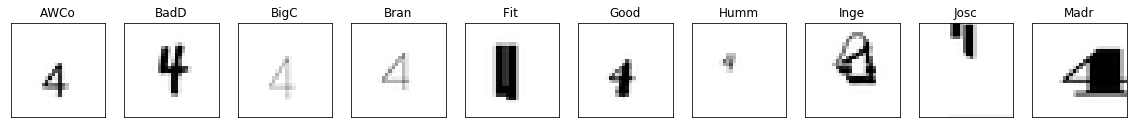

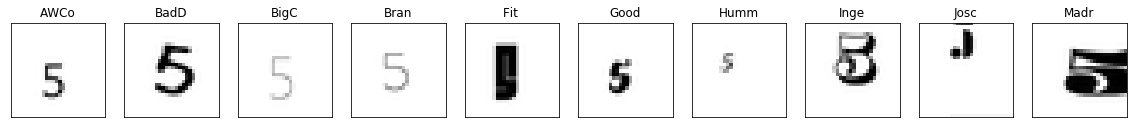

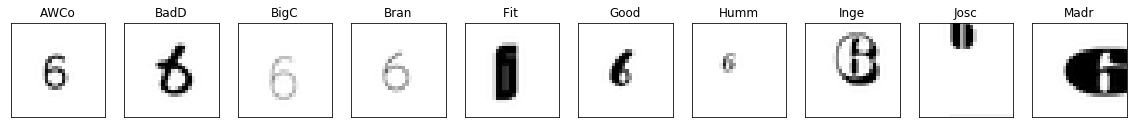

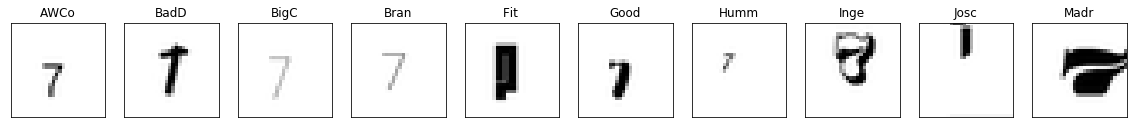

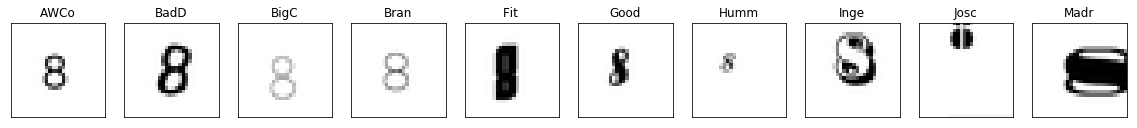

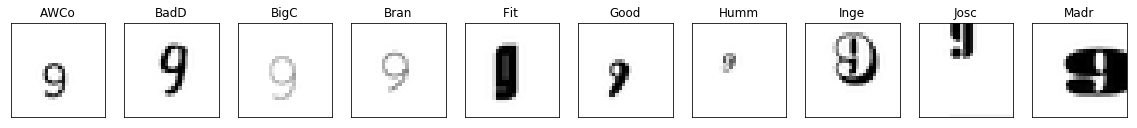

In [10]:
for num in range(10):
    file_path = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/example/{num}/'.format(num=num)
    plots(filepath=file_path)


# Summary of example fonts above:

### Awco, BadD & Good: these fonts are generally ok, may need the numbers to be centered.
### BigC & Bran: these fonts are too light from previous image thumbnailing, need obvious image normalization.
### Humm: Number too small, discard from ML dataset.
### Josc & Madr: Image out of bound, discard from ML dataset.
### Fit & Inge: Odd fonts per visual inspection, discard from ML dataset.

In [ ]:
def image_process (img,
                   filepath,
                   pixel_threshold = 200,
                   min_width = 2,
                   min_height = 10,
                   pos_threshold = 3):
    need_change = False
    np_img = np.array(img)
    img_size = np_img.shape
    # check 1st row of pixel that triggers threshold:
    for row_num, row in enumerate(np_img):
        first_row = None
        if min(row) <= pixel_threshold:
            first_row = row_num + 1
            break
        else:
            first_row = None
    for row_num, row in enumerate(np.flip(np_img), 0):
        last_row = None
        if min(row) <= pixel_threshold:
            last_row = img_size[0] - row_num
            break
    for row_num, row in enumerate(np.transpose(np_img)):
        first_col = None
        if min(row) <= pixel_threshold:
            first_col = row_num + 1
            break
    for row_num, row in enumerate(np.flip(np.transpose(np_img), 0)):
        last_col = None
        if min(row) <= pixel_threshold:
            last_col = img_size[1] - row_num
            break
    
    msg = '------ Tentatively OK'
    if first_row is None:
        msg = 'Number not dark enough'
        return msg
    
    if last_row - first_row < min_height:
        msg = 'Too short'
        return msg
    
    if '1/' not in filepath:
        if last_col - first_col < min_width:
            msg = 'Too narrow'
            return msg
    
    # Check if numbers are only partially captured. Discard these images.
    if first_row == 1:
        msg = 'Top on edge'
        return msg
    if last_row == img_size[0]:
        msg =  'Bottom on edge'
        return msg
    if first_col == 1:
        msg =  'Left on edge'
        return msg
    if last_col == img_size[1]:
        msg = 'Right on edge'
        return msg

    top_offset = first_row - (img_size[0] - last_row)
    left_offset = first_col - (img_size[1] - last_col)
    
    # Shift number to center if too far off to one side.
    if top_offset > pos_threshold:
        np_img = np.roll(np_img, -int(top_offset/2), 0)
        need_change = True
    elif top_offset < -pos_threshold:
        np_img = np.roll(np_img, -int(top_offset/2), 0)
        need_change = True
    if left_offset < -pos_threshold:
        np_img = np.roll(np_img, -int(left_offset/2), 1)
        need_change = True
    elif left_offset > pos_threshold:
        np_img = np.roll(np_img, -int(left_offset/2), 1)
        need_change = True

    # Determine if the image is already normalized.
    if np_img.min() != 0:
        need_change = True
    
    if need_change:
        np_normed = np.multiply(np_img - np_img.min(), np.array(255/np.ptp(np_img)))
        img = Image.fromarray(np_normed.astype(np.uint8))
    
    main_filepath = re.search(r'.*mined_numbers/\d/', filepath).group()[:-2]
    output_main_folder = 'Filtered/' + re.search(r'.*mined_numbers/\d/', filepath).group()[-2:]
    output_filename = re.search(r'mined_numbers/\d/.*', filepath).group()[16:]
    save_path = main_filepath + output_main_folder + output_filename
    
    img.save(save_path)
    
    return msg
    
    
file_counter = 0
tentatively_ok_counter = 0

# Make a folder to contain all filtered number images
os.mkdir(main_filepath + 'Filtered')

for num in range(10):
    ori_folder = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/{num}/*.png'.format(num=num)
    images = glob.glob(ori_folder)
    for image in images:
        img = Image.open(image)
        print(image)
        res = image_process(img, pixel_threshold = 200, filepath = image)
        print('______________________\n')
        if res == '------ Tentatively OK':
            tentatively_ok_counter += 1
        file_counter += 1
    print('Tentative OK percentage: {perc}%'.format(perc=round(float(tentatively_ok_counter/file_counter * 100),2)))
    print(tentatively_ok_counter)
    print(file_counter)
    

### Let's now discard some outlier fonts that are not easily detected by computer.

In [368]:
# Now, some images are still too difficult to recognize due to font ideaosyncrasies. Manually discard those fonts. Hint: looking through all 8's will make all bad fonts easily identifiable since number 8 has more complex structure therefore accetuates font flaws.

bad_fonts = ['Ingeborg Block',
             'HWT Star Ornaments Regular',
             'HWT Bulletin Script Two',
             'HWT Borders One Regular',
             'Hoosier Daddy Regular',
             'Copal Std Outline', 
             'BD Brick 2007 Regular',
             'Backspacer OT Round',
             'BD Nippori 2005',
             'BD Colonius Regular',
             'Rad Std Regular',
             'Pitch Black',
             'P22 FLW Exhibition Light',
             'Origin Super Condensed UltraLight',
             'Octynaz Regular',
             'HVD Steinzeit Regular',
             'Flyswim Regular',
             'Dimensions 100I',
             'Corpulent Regular',
             'Mati Regular',
             'Acier BAT Text Noir']

for num in range(10):
    ori_folder = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/Filtered/{num}/*.png'.format(num=num)
    images = glob.glob(ori_folder)
    for image in images:
        for bad_font in bad_fonts:
            if bad_font in image:
                os.remove(image)
                


### Examine the final processed images! Examples below are radomly selected.

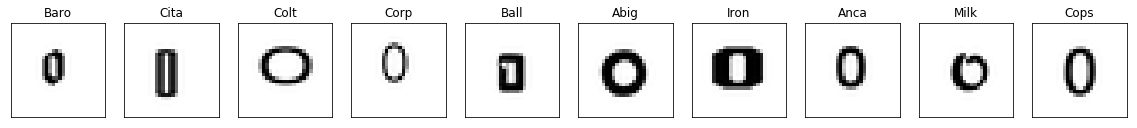

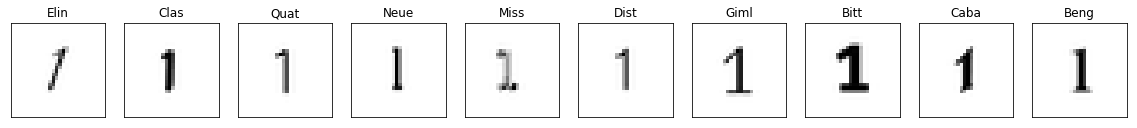

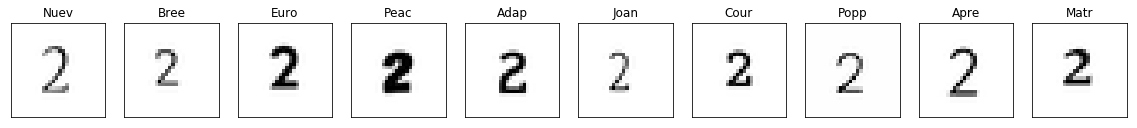

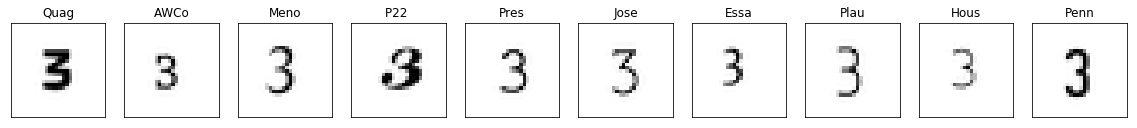

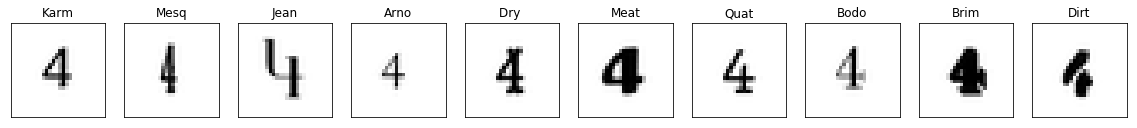

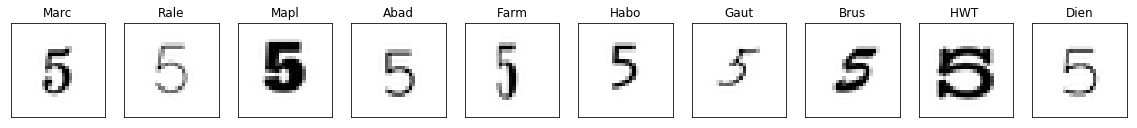

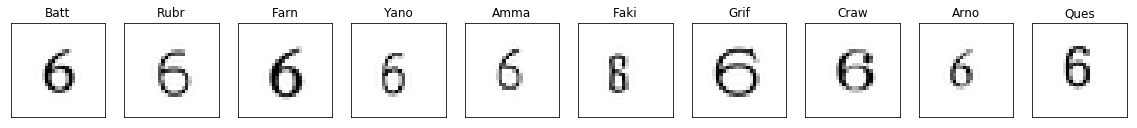

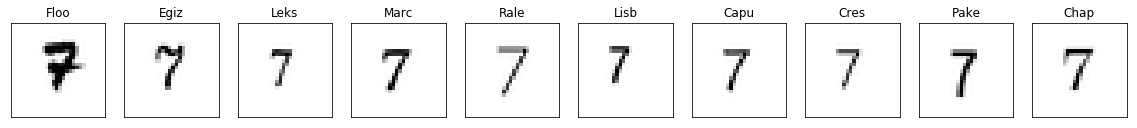

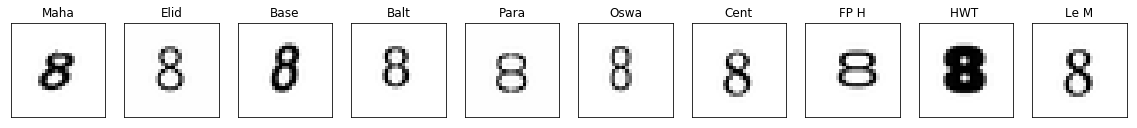

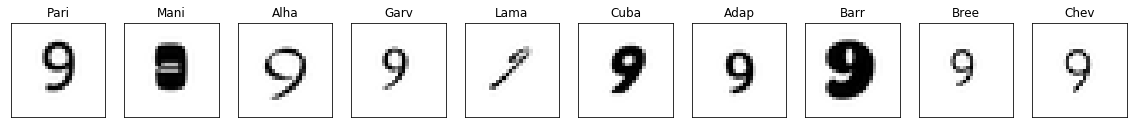

In [10]:
for num in range(10):
    file_path = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/Filtered/{num}/'.format(num=num)
    plots(filepath=file_path, random_state=True)

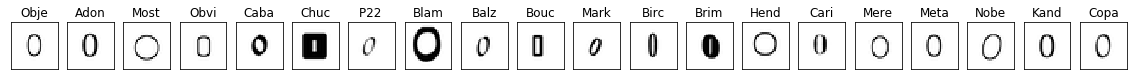

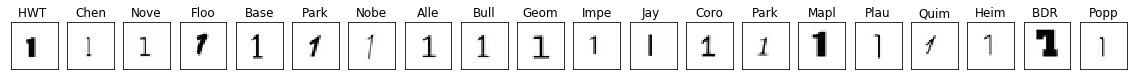

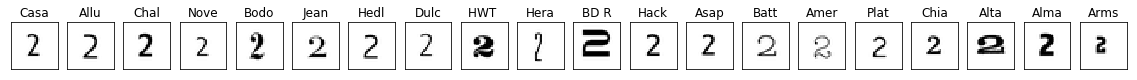

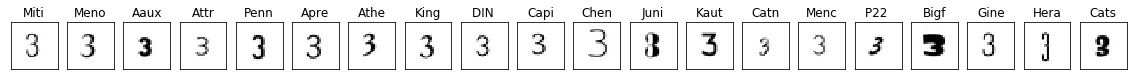

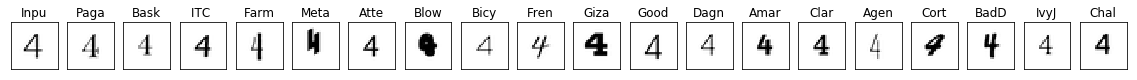

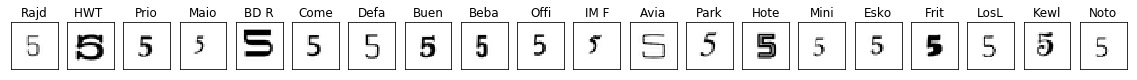

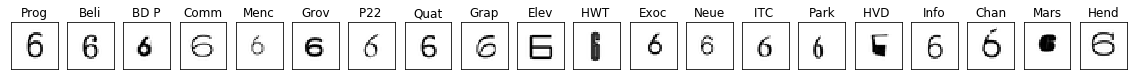

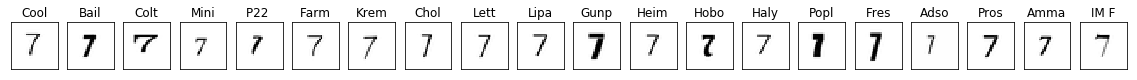

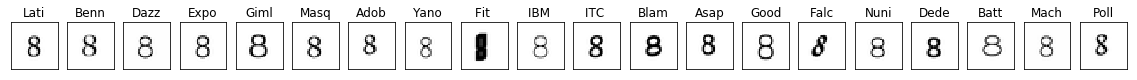

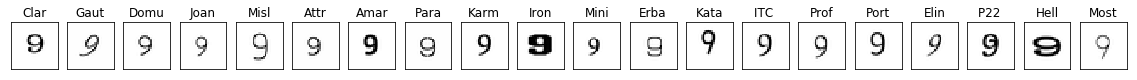

In [20]:
for num in range(10):
    file_path = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/Filtered/{num}/'.format(num=num)
    plots(filepath=file_path, columns=20, random_state=True)

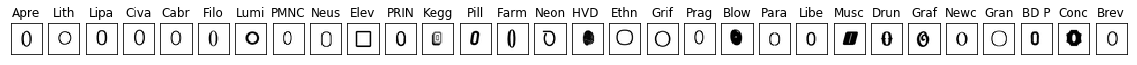

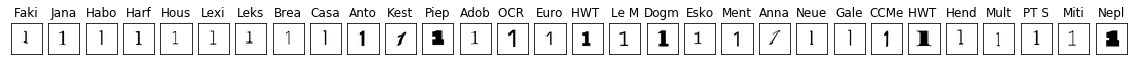

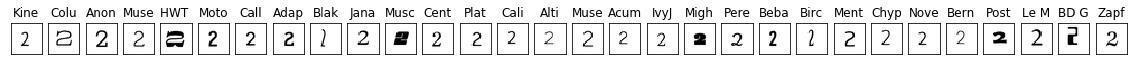

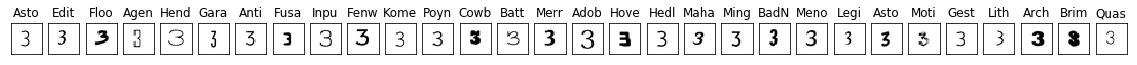

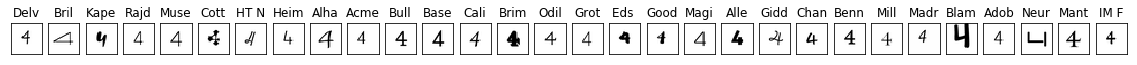

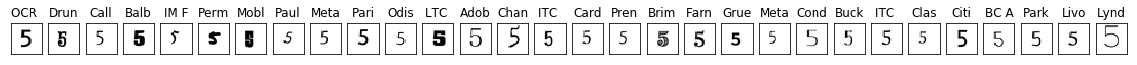

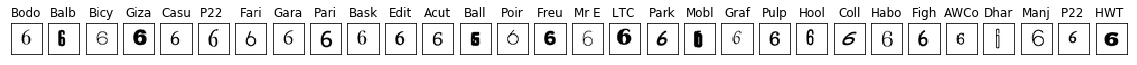

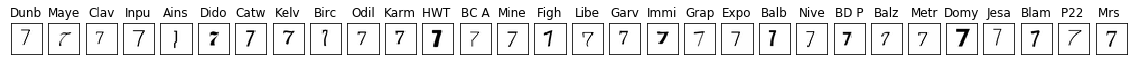

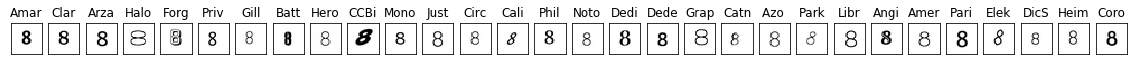

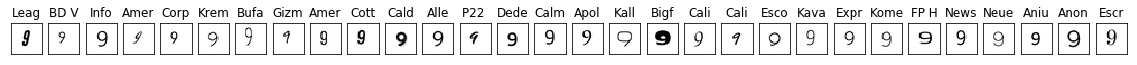

In [13]:
for num in range(10):
    file_path = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/Filtered/{num}/'.format(num=num)
    plots(filepath=file_path, columns=30, random_state=True)

### Pretty OK images!
### Let's see how many images made it through the filter.

In [21]:
file_count = 0

for num in range(10):
    orig_file_path = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/{num}/'.format(num=num)
    file_path = '/Users/zhonggao/Documents/Jupyter/test images/mined_numbers/Filtered/{num}/'.format(num=num)
    
    orig_num_files = len(glob.glob(orig_file_path + '*.png'))
    num_file = len(glob.glob(file_path + '*.png'))
    
    
    print('Number {num} has {num_file} qualified images from {orig_num_files} ({perc:.2f}%).'.format(num=num, num_file=num_file, orig_num_files=orig_num_files, perc=round(num_file / orig_num_files * 100, 2)))
    
    file_count += num_file

print('\nTotal qualified images: ', file_count)


Number 0 has 965 qualified images from 1237 (78.01%).
Number 1 has 928 qualified images from 1237 (75.02%).
Number 2 has 961 qualified images from 1237 (77.69%).
Number 3 has 1059 qualified images from 1237 (85.61%).
Number 4 has 1021 qualified images from 1237 (82.54%).
Number 5 has 1055 qualified images from 1237 (85.29%).
Number 6 has 1058 qualified images from 1237 (85.53%).
Number 7 has 1045 qualified images from 1237 (84.48%).
Number 8 has 1065 qualified images from 1237 (86.10%).
Number 9 has 1068 qualified images from 1237 (86.34%).

Total qualified images:  10225


## Mined >10,000 images for machine learning. Not at the level of MNIST dataset, but not bad!